# Random Forest Model for One-month-ahead Inflation Forecasting

The following GitHub repository was used as a starting point: https://github.com/o-meneses-covarrubias/inflation_forecasting

Methodology comes from the following article by Medeiros, Vasconcelos, Veiga, and Zilberman: [Forecasting Inflation in a Data-Rich Environment: The Benefits of Machine Learning Methods](https://www.tandfonline.com/doi/epdf/10.1080/07350015.2019.1637745?needAccess=true)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

font = {"family": "Noto Serif", "size": 12}
plt.rc("font", **font)
plt.rc("axes", labelpad=8, titlepad=16)

## Load Data

The data is focused on the UK economy. It is compiled from the following sources:

- CPIH annual rate, all items: [ONS](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23)
- Unemployment rate: [ONS](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/s2pu/lms)
- Employment rate: [ONS](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/s2pw/lms)
- GDP percentage change: [ONS](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyq/qna)
- Money in circulation: [BoE](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxAZxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=1989&TD=31&TM=Dec&TY=2025&FNY=Y&CSVF=TT&html.x=66&html.y=26&SeriesCodes=LPMB8H4&UsingCodes=Y&Filter=N&title=LPMB8H4&VPD=Y)
- BoE's Bank rate: [BoE](https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp)

In [2]:
data = pd.read_csv("uk-data.csv")
data["Date"] = pd.to_datetime(data["Date"], dayfirst=True)
data = data.set_index("Date")

Introduce a 1-month lag to all columns, except `CPIH` as current values are used as the truth values. The lagged CPIH is stored in a new `CPIH_lag` column.

In [3]:
lag = 1

data["CPIH_lag"] = data["CPIH"].shift(lag)
data["Unemployment"] = data["Unemployment"].shift(lag)
data["Employment"] = data["Employment"].shift(lag)
data["GDP"] = data["GDP"].shift(lag)
data["Money"] = data["Money"].shift(lag)
data["Bank_Rate"] = data["Bank_Rate"].shift(lag)
data = data.drop(index=data.index[0:lag])
data = data.replace(np.nan, 0)

data

,CPIH,Unemployment,Employment,GDP,Money,Bank_Rate,CPIH_lag
Date,,,,,,,
1989-02-01,5.8,0.0,0.0,0.5,16773.0,12.88,5.7
1989-03-01,5.9,0.0,0.0,0.5,16784.0,12.88,5.8
1989-04-01,5.6,0.0,0.0,0.5,16871.0,12.88,5.9
1989-05-01,5.9,0.0,0.0,0.6,16872.0,12.88,5.6
1989-06-01,5.8,0.0,0.0,0.6,16986.0,12.88,5.9
...,...,...,...,...,...,...,...
2023-05-01,7.9,4.0,76.0,0.0,94130.0,4.25,7.8
2023-06-01,7.3,4.2,75.7,0.0,94420.0,4.25,7.9
2023-07-01,6.4,4.2,75.7,0.0,94112.0,4.50,7.3


## Define Prediction Target and Split Into Training and Testing Tata

`y`, should only include the `CPIH` column as this shows inflation for the current month, and therefore serves as the truth value.

`x` should include all data, except `CPIH` as this will be what it is trying to predict. It also drops `Money`, which tracks the amount of money in circulation, and `Employment`, as the model performs better without them.


In [4]:
y = data["CPIH"]
x = data.drop(columns=["CPIH", "Employment", "Money"])

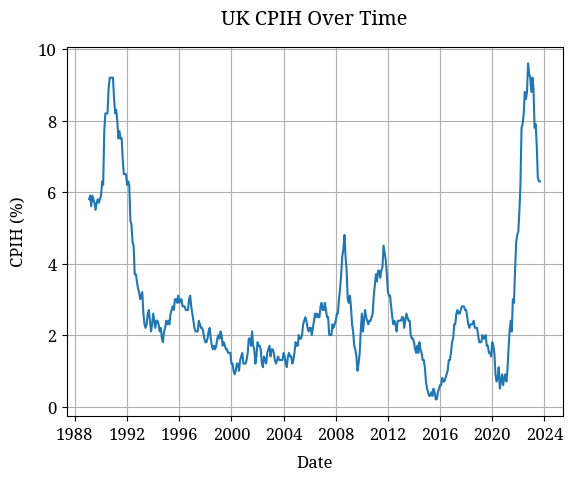

In [5]:
f1 = plt.figure(1)
plt.title("UK CPIH Over Time")
plt.plot(y)
plt.xlabel("Date")
plt.ylabel("CPIH (%)")
plt.grid()

Define training and test set. Train data will be from 1989 until 2022.

In [6]:
x_train = x.loc["1989-02-01":"2022-08-01"]
y_train = y.loc["1989-02-01":"2022-08-01"]

Test data is the last year from the data (Aug 2022–Aug 2023).

In [7]:
x_test = x.loc["2022-09-01":"2023-09-01"]
y_test = y.loc["2022-09-01":"2023-09-01"]

## Train Random Forest

Create a Random Forest model with hyperparameter tuning and fit it to the training data.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20],
    'max_features': [None, 'log2', 'sqrt'],
    'random_state': [42],
}

rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
rf.fit(x_train, y_train)

best_params = rf.best_params_
print("Best parameters: ", best_params)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters:  {'max_depth': 20, 'max_features': None, 'n_estimators': 100, 'random_state': 42}


Use the model to generate predictions from the testing data.

In [9]:
pred_train = rf.predict(x_train)
pred_test = rf.predict(x_test)

rf.best_score_

-0.33623344694297475

## Evaluate model

Calculate the Mean Absolute Error (MAE) for the training and testing data.


In [10]:
print(
    f"The RF on training set has MAE of {round(mean_absolute_error(pred_train, y_train), 4)}"
)
print(
    f"The RF on test set has MAE of {round(mean_absolute_error(pred_test, y_test), 4)}"
)

The RF on training set has MAE of 0.0826
The RF on test set has MAE of 0.4633


Plot the predictions against the actual values


<Figure size 640x480 with 0 Axes>

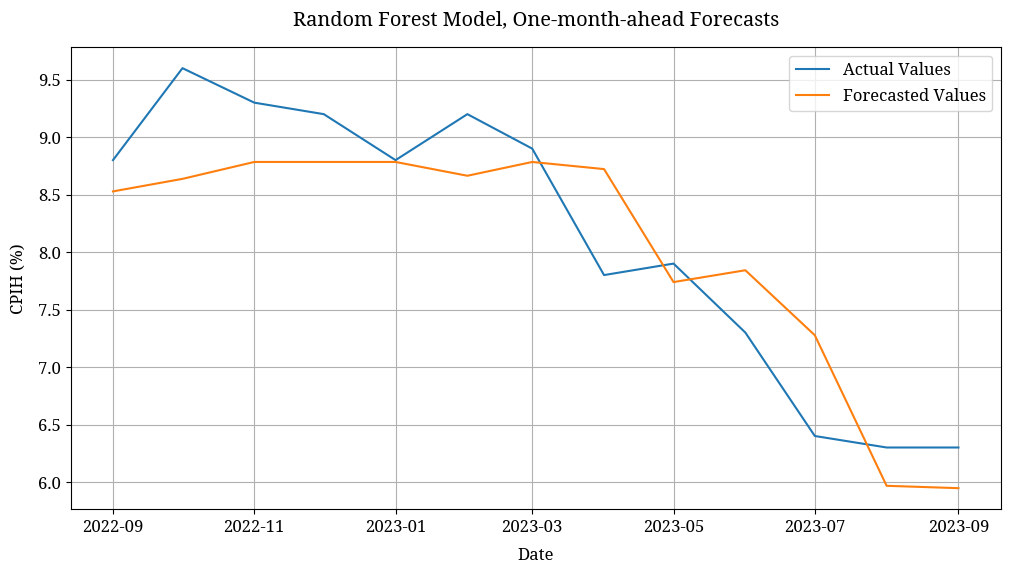

In [11]:
pred_test_series = pd.Series(pred_test, index=y_test.index)

f2 = plt.figure(2)
plt.figure(figsize=(12, 6))
plt.title("Random Forest Model, One-month-ahead Forecasts")
plt.plot(y_test, label="Actual Values")
plt.plot(pred_test_series, label="Forecasted Values")
plt.xlabel("Date")
plt.ylabel("CPIH (%)")
plt.legend()
plt.grid()

plt.savefig("rf-pred.pdf")